In [3]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from scipy.stats import zscore

import gym
from gym import spaces
import joblib

import matplotlib.pyplot as plt

import tensorflow as tf
from keras import __version__
tf.keras.__version__ = __version__

from random import randint
from tqdm import tqdm

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

import warnings
warnings.filterwarnings("ignore")

In [6]:
data = pd.read_csv('./Datasets/test.csv', index_col=0)

In [7]:
data['datetime'] = pd.to_datetime(data['datetime'])

data['hour'] = data['datetime'].dt.hour
data['day_of_week'] = data['datetime'].dt.dayofweek


data = data.drop(columns=["datetime"])

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 287797 entries, 919048 to 1407918
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   eta                    287797 non-null  float64
 1   route_distance         287797 non-null  int64  
 2   route_duration         287797 non-null  int64  
 3   source_latitude        287797 non-null  float64
 4   source_longitude       287797 non-null  float64
 5   destination_latitude   287797 non-null  float64
 6   destination_longitude  287797 non-null  float64
 7   month                  287797 non-null  int64  
 8   day                    287797 non-null  int64  
 9   hour                   287797 non-null  int32  
 10  day_of_week            287797 non-null  int32  
 11  part_of_day            287797 non-null  object 
 12  source_h3              287797 non-null  object 
 13  destination_h3         287797 non-null  object 
dtypes: float64(5), int32(2), int64(4), 

In [9]:
data['source_h3'] = data['source_h3'].astype('category').cat.codes
data['destination_h3'] = data['destination_h3'].astype('category').cat.codes
data['part_of_day'] = data['part_of_day'].astype('category').cat.codes
data['ride_id'] = data.index
data = data[['ride_id', 'eta', 'route_distance', 'route_duration', 'source_h3', 'destination_h3', 
                  'month', 'day', 'hour', 'day_of_week', 'part_of_day']]

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 287797 entries, 919048 to 1407918
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ride_id         287797 non-null  int64  
 1   eta             287797 non-null  float64
 2   route_distance  287797 non-null  int64  
 3   route_duration  287797 non-null  int64  
 4   source_h3       287797 non-null  int16  
 5   destination_h3  287797 non-null  int16  
 6   month           287797 non-null  int64  
 7   day             287797 non-null  int64  
 8   hour            287797 non-null  int32  
 9   day_of_week     287797 non-null  int32  
 10  part_of_day     287797 non-null  int8   
dtypes: float64(1), int16(2), int32(2), int64(5), int8(1)
memory usage: 18.9 MB


In [11]:
passenger_acceptance_model = lgb.Booster(model_file='passenger_model.txt')
driver_acceptance_model = lgb.Booster(model_file='driver_model.txt')


In [12]:
data['pickup_distance'] = data['eta'] * (40 / 60)

In [14]:
data

,ride_id,eta,route_distance,route_duration,source_h3,destination_h3,month,day,hour,day_of_week,part_of_day,pickup_distance
919048,919048,3.0,4255,603,324,578,10,2,0,0,3,2.000000
1074223,1074223,3.0,10540,1536,230,161,10,2,0,0,3,2.000000
1194102,1194102,4.0,6279,831,320,615,10,2,0,0,3,2.666667
1721900,1721900,4.0,2434,426,592,257,10,2,0,0,3,2.666667
1671516,1671516,4.0,11591,1368,62,141,10,2,0,0,3,2.666667
...,...,...,...,...,...,...,...,...,...,...,...,...
2026192,2026192,7.0,7862,1079,164,214,10,9,23,0,3,4.666667
757886,757886,1.0,11920,1722,322,35,10,9,23,0,3,0.666667
161319,161319,2.0,3009,385,576,321,10,9,23,0,3,1.333333
425634,425634,1.0,5072,779,216,669,10,9,23,0,3,0.666667


In [15]:
class RideEnv(gym.Env):
    def __init__(self, data, passenger_model, driver_model):
        super(RideEnv, self).__init__()
        self.data = data
        self.passenger_model = passenger_model
        self.driver_model = driver_model
        self.current_step = 0

        # Define action and observation space
        self.action_space = spaces.Discrete(100)  # Prices from 1 to 100
        self.observation_space = spaces.Box(low=0, high=1, shape=(11,), dtype=np.float32)

    def reset(self):
        self.current_step = 0
        obs = self._get_observation()
        return obs

    def _get_observation(self):
        row = self.data.iloc[self.current_step]
        features = row[['pickup_distance', 'eta', 'route_distance', 'route_duration', 'source_h3', 'destination_h3', 'month', 'day', 'hour', 'day_of_week', 'part_of_day']].values
        return features

    def step(self, action):
        price = action + 1
        row = self.data.iloc[self.current_step]

        # Create features for passenger and driver models
        features_passenger = np.array([price, row['eta'],
                                       row['route_distance'],
                                       row['route_duration'],
                                       row['source_h3'],
                                       row['destination_h3'],
                                       row['month'],
                                       row['day'],
                                       row['hour'],
                                       row['day_of_week'],
                                       row['part_of_day']]).reshape(1, -1)
        features_driver = np.array([price,
                                    row['eta'],
                                    row['pickup_distance'],
                                    row['route_distance'],
                                    row['route_duration'],
                                    row['source_h3'],
                                    row['destination_h3'],
                                    row['month'],
                                    row['day'],
                                    row['hour'],
                                    row['day_of_week'],
                                    row['part_of_day']]).reshape(1, -1)

        # Predict probabilities
        passenger_prob = self.passenger_model.predict(features_passenger)[0]
        driver_prob = self.driver_model.predict(features_driver)[0]
        success_prob = passenger_prob * driver_prob

        reward = success_prob
        self.current_step += 1

        done = self.current_step >= len(self.data)
        obs = self._get_observation() if not done else np.zeros(self.observation_space.shape)  # Return a zero observation if done

        return obs, reward, done, {}

    def render(self, mode='human'):
        pass

env = RideEnv(data, passenger_acceptance_model, driver_acceptance_model)

# Define a neural network model
model = Sequential()
model.add(Flatten(input_shape=(1, env.observation_space.shape[0])))
model.add(Dense(24))
model.add(Activation('relu'))
model.add(Dense(24))
model.add(Activation('relu'))
model.add(Dense(env.action_space.n))
model.add(Activation('linear'))

# Configure and compile the agent
memory = SequentialMemory(limit=50000, window_length=1)
policy = BoltzmannQPolicy()
dqn = DQNAgent(model=model, nb_actions=env.action_space.n, memory=memory, nb_steps_warmup=10, target_model_update=1e-2, policy=policy)

dqn.compile(tf.keras.optimizers.legacy.Adam(learning_rate=1e-3), metrics=['mae'])


2024-07-02 22:36:53.069182: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-07-02 22:36:53.160302: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_2_1/bias/Assign' id:145 op device:{requested: '', assigned: ''} def:{{{node dense_2_1/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_2_1/bias, dense_2_1/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [16]:
# Train the agent
dqn.fit(env, nb_steps=50000, visualize=True, verbose=1)

Training for 50000 steps ...
Interval 1 (0 steps performed)
    1/10000 [..............................] - ETA: 10:28 - reward: 0.2839

2024-07-02 22:37:00.693201: W tensorflow/c/c_api.cc:305] Operation '{name:'activation_2/activation_2/Identity' id:76 op device:{requested: '', assigned: ''} def:{{{node activation_2/activation_2/Identity}} = Identity[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_2/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-07-02 22:37:00.706319: W tensorflow/c/c_api.cc:305] Operation '{name:'count_1/Assign' id:295 op device:{requested: '', assigned: ''} def:{{{node count_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_1, count_1/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new

10000/10000 [==============================] - 22s 2ms/step - reward: 0.3318
Interval 2 (10000 steps performed)
10000/10000 [==============================] - 22s 2ms/step - reward: 0.3408
Interval 3 (20000 steps performed)
10000/10000 [==============================] - 21s 2ms/step - reward: 0.3094
Interval 4 (30000 steps performed)
10000/10000 [==============================] - 22s 2ms/step - reward: 0.3143
Interval 5 (40000 steps performed)
10000/10000 [==============================] - 23s 2ms/step - reward: 0.3773
done, took 109.560 seconds


In [17]:
# Save the weights after training
dqn.save_weights('dqn_ride_weights.h5f', overwrite=True)

def custom_test(agent, env, nb_episodes=10):
    results = []

    for episode in tqdm(range(nb_episodes)):
        obs = env.reset()
        done = False
        episode_results = []

        while not done:
            # Ensure correct input shape (1, 1, 11)
            action = agent.forward(obs)
            obs, reward, done, info = env.step(action)
            price = action + 1  # Assuming action directly corresponds to price
            row = env.data.iloc[env.current_step - 1]
            ride_id = row['ride_id']
            episode_results.append({
                'episode': episode,
                'ride_id': ride_id,
                'price': price,
                'reward': reward,
                'eta': row['eta'],
                'route_distance': row['route_distance'],
                'route_duration': row['route_duration'],
                'source_h3': row['source_h3'],
                'destination_h3': row['destination_h3'],
                'month': row['month'],
                'day': row['day'],
                'hour': row['hour'],
                'day_of_week': row['day_of_week'],
                'part_of_day': row['part_of_day'],
                'pickup_distance': row['pickup_distance']
            })

        results.extend(episode_results)
    
    return results

# Load the weights for evaluation
dqn.load_weights('dqn_ride_weights.h5f')

# Test the agent with custom function and get results
test_results = custom_test(dqn, env, nb_episodes=2)

100%|████████████████████████████████████████████| 2/2 [05:20<00:00, 160.40s/it]


In [18]:
result_df = pd.DataFrame(test_results)

In [19]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 575594 entries, 0 to 575593
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   episode          575594 non-null  int64  
 1   ride_id          575594 non-null  float64
 2   price            575594 non-null  int64  
 3   reward           575594 non-null  float64
 4   eta              575594 non-null  float64
 5   route_distance   575594 non-null  float64
 6   route_duration   575594 non-null  float64
 7   source_h3        575594 non-null  float64
 8   destination_h3   575594 non-null  float64
 9   month            575594 non-null  float64
 10  day              575594 non-null  float64
 11  hour             575594 non-null  float64
 12  day_of_week      575594 non-null  float64
 13  part_of_day      575594 non-null  float64
 14  pickup_distance  575594 non-null  float64
dtypes: float64(13), int64(2)
memory usage: 65.9 MB


In [20]:
result_df

,episode,ride_id,price,reward,eta,route_distance,route_duration,source_h3,destination_h3,month,day,hour,day_of_week,part_of_day,pickup_distance
0,0,919048.0,6,0.258339,3.0,4255.0,603.0,324.0,578.0,10.0,2.0,0.0,0.0,3.0,2.000000
1,0,1074223.0,42,0.145336,3.0,10540.0,1536.0,230.0,161.0,10.0,2.0,0.0,0.0,3.0,2.000000
2,0,1194102.0,1,0.125699,4.0,6279.0,831.0,320.0,615.0,10.0,2.0,0.0,0.0,3.0,2.666667
3,0,1721900.0,8,0.252274,4.0,2434.0,426.0,592.0,257.0,10.0,2.0,0.0,0.0,3.0,2.666667
4,0,1671516.0,80,0.074199,4.0,11591.0,1368.0,62.0,141.0,10.0,2.0,0.0,0.0,3.0,2.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575589,1,2026192.0,98,0.058524,7.0,7862.0,1079.0,164.0,214.0,10.0,9.0,23.0,0.0,3.0,4.666667
575590,1,757886.0,25,0.214639,1.0,11920.0,1722.0,322.0,35.0,10.0,9.0,23.0,0.0,3.0,0.666667
575591,1,161319.0,89,0.442212,2.0,3009.0,385.0,576.0,321.0,10.0,9.0,23.0,0.0,3.0,1.333333
575592,1,425634.0,94,0.154656,1.0,5072.0,779.0,216.0,669.0,10.0,9.0,23.0,0.0,3.0,0.666667


In [28]:
qlearning_avg_reward = results_df_clean['reward'].mean()

# Calculate overall average reward for random policy
random_avg_reward = random_results_df_clean['reward'].mean()

print(f"Q-learning Average Reward: {qlearning_avg_reward}")


Q-learning Average Reward: 0.29794945426530434


In [29]:
# Group by price and calculate the average reward for each price for Q-learning policy
qlearning_price_analysis = results_df_clean.groupby('price')['reward'].mean().reset_index()


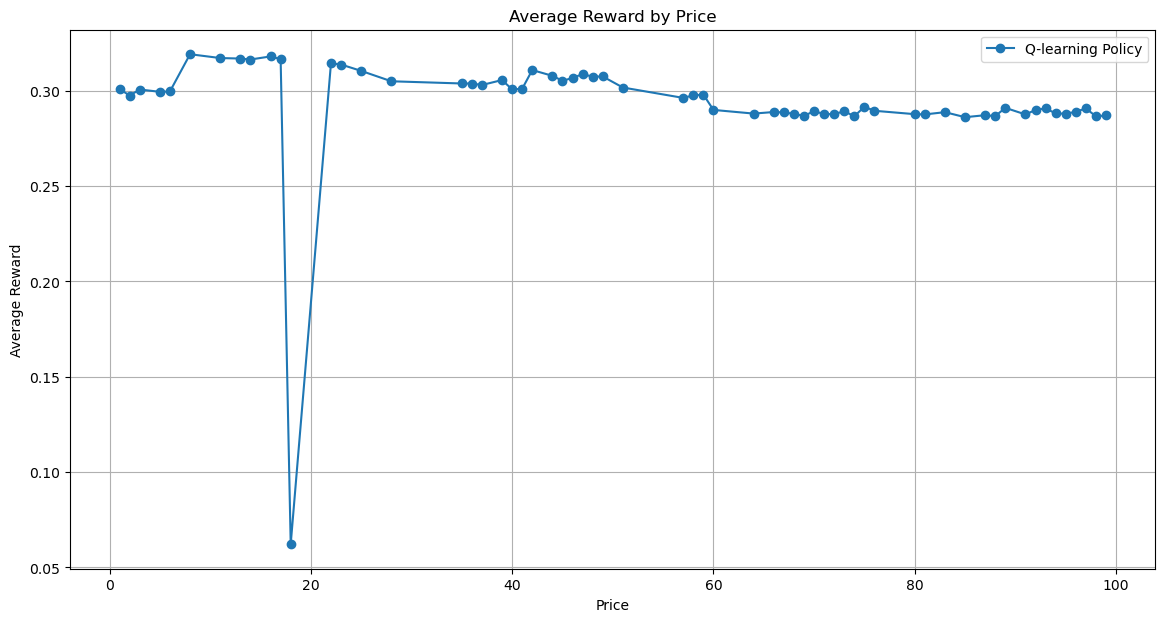

In [30]:
# Plot the average rewards by price for both policies
plt.figure(figsize=(14, 7))

plt.plot(qlearning_price_analysis['price'], qlearning_price_analysis['reward'], marker='o', label='Q-learning Policy')

plt.title('Average Reward by Price')
plt.xlabel('Price')
plt.ylabel('Average Reward')
plt.legend()
plt.grid(True)
plt.show()

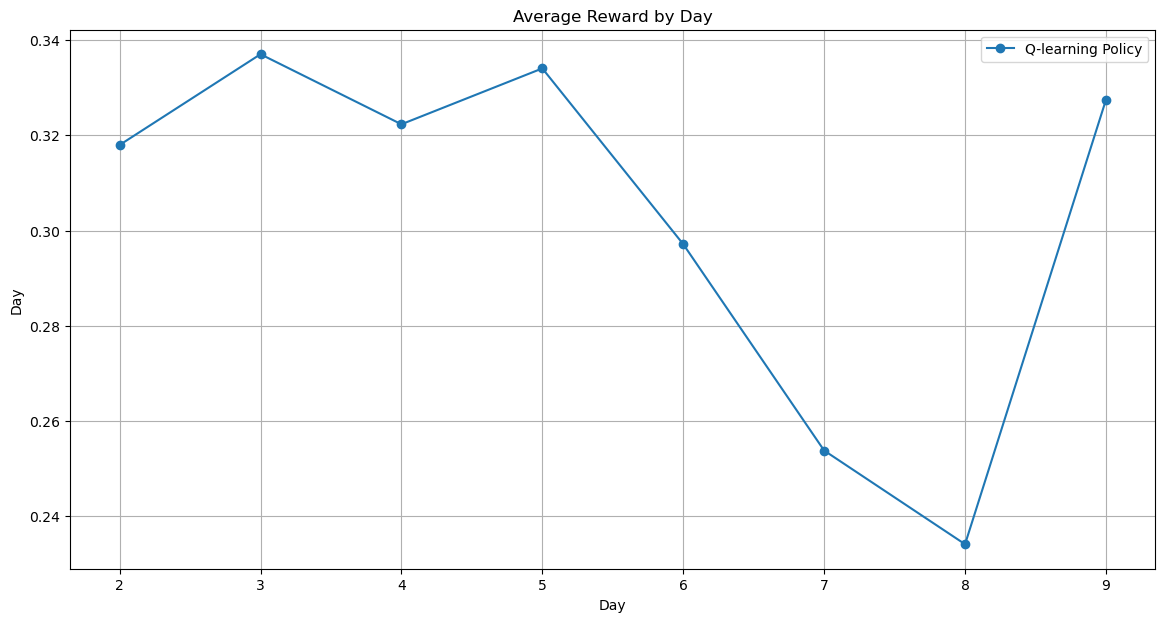

In [31]:
# Group by price and calculate the average reward for each price for Q-learning policy
qlearning_price_analysis = result_df.groupby('day')['reward'].mean().reset_index()

# Plot the average rewards by price for both policies
plt.figure(figsize=(14, 7))

plt.plot(qlearning_price_analysis['day'], qlearning_price_analysis['reward'], marker='o', label='Q-learning Policy')

plt.title('Average Reward by Day')
plt.xlabel('Day')
plt.ylabel('Day')
plt.legend()
plt.grid(True)
plt.show()

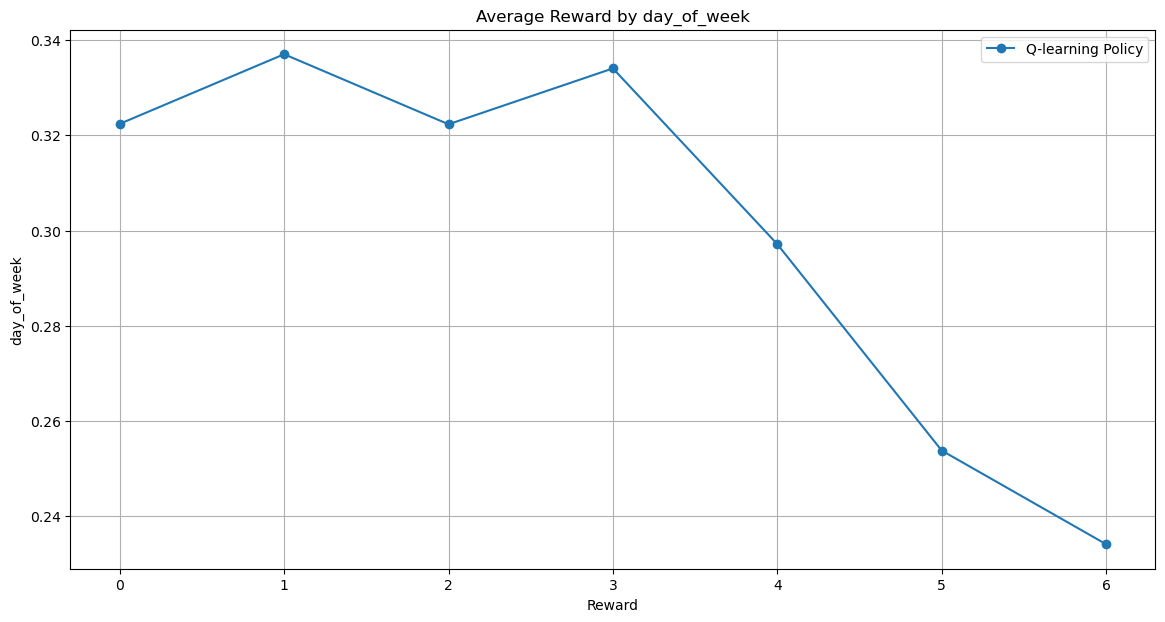

In [32]:
# Group by price and calculate the average reward for each price for Q-learning policy
qlearning_price_analysis = result_df.groupby('day_of_week')['reward'].mean().reset_index()

# Plot the average rewards by price for both policies
plt.figure(figsize=(14, 7))

plt.plot(qlearning_price_analysis['day_of_week'], qlearning_price_analysis['reward'], marker='o', label='Q-learning Policy')

plt.title('Average Reward by day_of_week')
plt.xlabel('Reward')
plt.ylabel('day_of_week')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
# Define success threshold
success_threshold = 0.5

# Calculate success rate for Q-learning policy
result_df['successful'] = result_df['reward'] > success_threshold
qlearning_success_rate = result_df.groupby('ride_id')['successful'].mean().reset_index()
qlearning_success_rate.rename(columns={'successful': 'qlearning_success_rate'}, inplace=True)

qlearning_success_rate

,ride_id,qlearning_success_rate
0,6.0,0.0
1,10.0,0.0
2,38.0,0.0
3,40.0,0.0
4,45.0,0.0
...,...,...
287792,2026184.0,0.0
287793,2026188.0,0.0
287794,2026190.0,0.0
287795,2026191.0,0.0


In [39]:
qlearning_success_rate.qlearning_success_rate.value_counts()

qlearning_success_rate
0.0    229860
1.0     47219
0.5     10718
Name: count, dtype: int64

In [ ]:
qlearning_success_rate.qlearning_success_rate 

In [34]:
# Calculate average reward for each ride_id for Q-learning policy
qlearning_avg_reward = result_df.groupby('ride_id')['reward'].mean().reset_index()
qlearning_avg_reward.rename(columns={'reward': 'qlearning_avg_reward'}, inplace=True)

qlearning_avg_reward

,ride_id,qlearning_avg_reward
0,6.0,0.496869
1,10.0,0.314757
2,38.0,0.131449
3,40.0,0.137125
4,45.0,0.130230
...,...,...
287792,2026184.0,0.019972
287793,2026188.0,0.065059
287794,2026190.0,0.088413
287795,2026191.0,0.303580


In [38]:
results_df_clean

,episode,ride_id,price,reward,eta,route_distance,route_duration,source_h3,destination_h3,month,day,hour,day_of_week,part_of_day,pickup_distance
0,0,919048.0,6,0.258339,3.0,4255.0,603.0,324.0,578.0,10.0,2.0,0.0,0.0,3.0,2.000000
1,0,1074223.0,42,0.145336,3.0,10540.0,1536.0,230.0,161.0,10.0,2.0,0.0,0.0,3.0,2.000000
2,0,1194102.0,1,0.125699,4.0,6279.0,831.0,320.0,615.0,10.0,2.0,0.0,0.0,3.0,2.666667
3,0,1721900.0,8,0.252274,4.0,2434.0,426.0,592.0,257.0,10.0,2.0,0.0,0.0,3.0,2.666667
4,0,1671516.0,80,0.074199,4.0,11591.0,1368.0,62.0,141.0,10.0,2.0,0.0,0.0,3.0,2.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575589,1,2026192.0,98,0.058524,7.0,7862.0,1079.0,164.0,214.0,10.0,9.0,23.0,0.0,3.0,4.666667
575590,1,757886.0,25,0.214639,1.0,11920.0,1722.0,322.0,35.0,10.0,9.0,23.0,0.0,3.0,0.666667
575591,1,161319.0,89,0.442212,2.0,3009.0,385.0,576.0,321.0,10.0,9.0,23.0,0.0,3.0,1.333333
575592,1,425634.0,94,0.154656,1.0,5072.0,779.0,216.0,669.0,10.0,9.0,23.0,0.0,3.0,0.666667


In [40]:
results_df_clean['success'] = (results_df_clean['reward'] >= 0.5).astype(int)


In [42]:
results_df_clean.to_csv("simulation_data.csv")